In [785]:
import numpy as np
from scipy.stats import gamma, uniform
from math import e, log, pi, sin, cos, asin, atan2, exp
import random

## Setup data
1. We use 300 random samples with a set random state to ensure we always get the same repro data.
2. We standard scale to ensure the same distance between different stats

In [786]:
from sklearn.datasets._samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4, n_features=2,
                       cluster_std=0.60, random_state=0)

In [787]:
import pandas as pd 

df = pd.DataFrame(X)
df.head()

,0,1
0,0.836857,2.136359
1,-1.413658,7.409623
2,1.155213,5.099619
3,-1.018616,7.814915
4,1.271351,1.892542


In [788]:
max_value = np.max(X)
max_value

9.282932223367844

## Math

- Radius $r$
- Privacy level $l$
- The differential privacy is reached using $\epsilon = l/r$
- $X$ = Points of interest
- $Z$ = Possible reported values
- For every $x \in X $ we report a perturbed point $z \in Z$


In [789]:
radius = 0.5 # radius r
level = 2 #privacy level l
epsilon = 4
print(epsilon)

4


### Laplace (plain)
$f(x, \mu, \lambda) = \frac{1}{2\lambda}exp(-\frac{|x - \mu|}{\lambda})$

"This distribution has been used in the literature to add noise to query results on statistical databases, with μ set to be the actual answer"

In [790]:
import numpy as np
def laplace(x, mu, b):
    return (1.0 / (2.0 * b)) * e * (-abs(x - mu) / b)

PDF Laplace distance modification. This modification is achieved by replacing $|x - \mu|$ by $d(x, \mu)$

PDF for laplace
$pdf = \frac{\epsilon}{2}exp(-\epsilon|x-\mu|)$

Modified for distance:
$D\epsilon(x0)(x) = \frac{\epsilon^2}{2*\pi}e(-\epsilon d(x0, x))$

In [791]:
import numpy as np
"""
def my_func(x, x0, eps):
    
    Compute the function f(x) = (eps**2 / (2 * np.pi)) * np.exp(-eps * np.linalg.norm(x - x0))

    # Compute the Euclidean distance between x and x0
    d = np.sqrt((x[:,0] - x0[0])**2 + (x[:,1] - x0[1])**2)
    
    # Compute the function value at each x
    return (eps**2 / (2 * np.pi)) * e * -(eps * d)

# Example usage:
x = np.random.randn(100, 2)
x0 = np.array([0, 0])

y = my_func(x, x0, eps)

plt.scatter(x[:, 0], x[:, 1], c=y)
plt.colorbar()
plt.title(r'$\frac{\epsilon^2}{2\pi}e^{-\epsilon d(x_0, x)}$ (planar laplace)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
"""


"\ndef my_func(x, x0, eps):\n    \n    Compute the function f(x) = (eps**2 / (2 * np.pi)) * np.exp(-eps * np.linalg.norm(x - x0))\n\n    # Compute the Euclidean distance between x and x0\n    d = np.sqrt((x[:,0] - x0[0])**2 + (x[:,1] - x0[1])**2)\n    \n    # Compute the function value at each x\n    return (eps**2 / (2 * np.pi)) * e * -(eps * d)\n\n# Example usage:\nx = np.random.randn(100, 2)\nx0 = np.array([0, 0])\n\ny = my_func(x, x0, eps)\n\nplt.scatter(x[:, 0], x[:, 1], c=y)\nplt.colorbar()\nplt.title(r'$\x0crac{\\epsilon^2}{2\\pi}e^{-\\epsilon d(x_0, x)}$ (planar laplace)')\nplt.xlabel('x')\nplt.ylabel('y')\nplt.show()\n"

Draw a random point from: $D\epsilon(x0)(x) = \frac{\epsilon^2}{2*\pi}e(-\epsilon d(x0, x))$

1. Modifying it to polar laplace: $D\epsilon(r)(\theta) = \frac{\epsilon^2}{2*\pi}d(x0, x) e(-\epsilon d(x0, x))$

2. radius: $D\epsilon,R(r) = \int_{0}^{2*\pi} D\epsilon(r, \theta) D\theta = \epsilon*2 r e(-\epsilon r)$

3. angle: $D\epsilon, \Theta(\theta) = \int_{0}^\infty D\epsilon(r, \theta) dr = \frac{1}{2*\pi}$ 

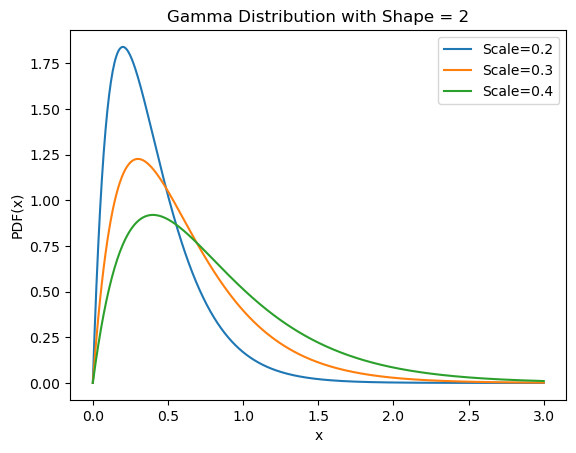

In [792]:

import matplotlib.pyplot as plt

def compute_d_radius(eps):
    return gamma(2, scale=eps)
x2= np.linspace(0, 3, 500)

for scale in [0.2, 0.3, 0.4]:
    # Generate a gamma distribution
    gamma_dist = compute_d_radius(scale)

    # Calculate the PDF values for each x-value
    pdf = gamma_dist.pdf(x2)

    # Plot the PDF
    plt.plot(x2, pdf, label=f"Scale={scale}")

plt.title("Gamma Distribution with Shape = 2")
plt.xlabel("x")
plt.ylabel("PDF(x)")
plt.legend()
plt.show()

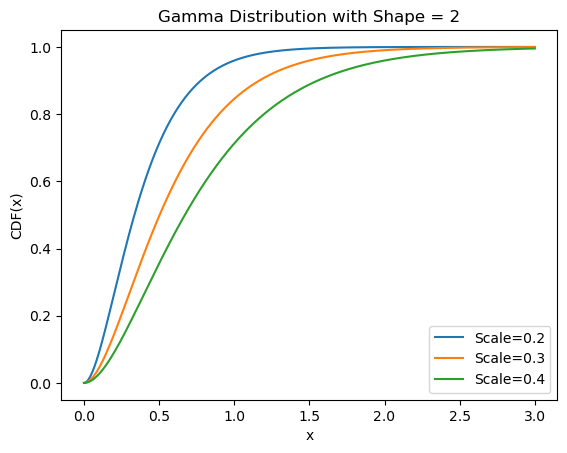

In [793]:
for scale in [0.2, 0.3, 0.4]:
    # Generate a gamma distribution
    gamma_dist = compute_d_radius(scale)

    # Calculate the PDF values for each x-value
    pdf = gamma_dist.cdf(x2)

    # Plot the PDF
    plt.plot(x2, pdf, label=f"Scale={scale}")

plt.title("Gamma Distribution with Shape = 2")
plt.xlabel("x")
plt.ylabel("CDF(x)")
plt.legend()
plt.show()

$C_\epsilon^{-1}$ is the inverse gamma CDF 

1. We modify planar laplace to include distance 


In [794]:

"""
## Compute Dr(r) 
def polar_laplace(x, x0, eps):
    ## Compute the function f(x) = (eps**2 / (2 * np.pi)) * np.exp(-eps * np.linalg.norm(x - x0))
    # Compute the Euclidean distance between x and x0
    d = np.sqrt((x[:,0] - x0[0])**2 + (x[:,1] - x0[1])**2)
    
    # Compute the function value at each x
    #return (eps**2 / (2 * np.pi)) * d * np.exp(-eps * d)
    return eps**2 * d * e * -(eps * d) 

y = polar_laplace(x, x0, eps)

import matplotlib.pyplot as plt
plt.scatter(x[:, 0], x[:, 1], c=y)
plt.colorbar()
plt.title(r'$\epsilon^2 * d(x0, x) * e^{-\epsilon d(x0, x)}$ (polar laplace)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()"""


"\n## Compute Dr(r) \ndef polar_laplace(x, x0, eps):\n    ## Compute the function f(x) = (eps**2 / (2 * np.pi)) * np.exp(-eps * np.linalg.norm(x - x0))\n    # Compute the Euclidean distance between x and x0\n    d = np.sqrt((x[:,0] - x0[0])**2 + (x[:,1] - x0[1])**2)\n    \n    # Compute the function value at each x\n    #return (eps**2 / (2 * np.pi)) * d * np.exp(-eps * d)\n    return eps**2 * d * e * -(eps * d) \n\ny = polar_laplace(x, x0, eps)\n\nimport matplotlib.pyplot as plt\nplt.scatter(x[:, 0], x[:, 1], c=y)\nplt.colorbar()\nplt.title(r'$\\epsilon^2 * d(x0, x) * e^{-\\epsilon d(x0, x)}$ (polar laplace)')\nplt.xlabel('x')\nplt.ylabel('y')\nplt.show()"

In [795]:
import math
from scipy.special import lambertw
#Convert degrees to radians
def rad_of_deg(ang):
	return np.radians(ang)

#Convert radians to degrees
def deg_of_rad(ang):
	return np.degrees(ang)

#Define Lambda distribution
def LambertW(x):
	#Min diff decides when the while loop ends
	min_diff = 1e-10
	if (x == -1 / np.e):
		return -1
	elif ((x < 0) and (x > -1/np.e)):
		q = np.log(-x)
		p = 1
		while (abs(p-q) > min_diff):
			p = (q * q + x / np.exp(q)) / (q + 1)
			q = (p * p + x / np.exp(p)) / (p + 1)
		#determine the precision of the float number to be returned
		return (np.round(1000000 * q) / 1000000)
	elif (x == 0):
		return 0
	else:
		return 0

def inverseCumulativeGamma (eps, p): 
    x = (p - 1) / np.e
    return -(LambertW(x) + 1)/eps

def polar_to_cartesian (distance, theta): 
    x, y = distance * np.cos(theta), distance * np.sin(theta)
    return x,y


def addVectorToPoint(point, distance, angle, radius):
	x1, y1 = point
	x2 = x1 + (distance * np.cos(angle))
	y2 = y1 + (distance * np.sin(angle))
	return x2, y2



In [796]:
def generate_laplace_noise(eps, x, y): 
    theta = np.random.rand()*np.pi*2
    p = random.random()
    r = inverseCumulativeGamma(eps, p) # draw radius distance
    return addVectorToPoint([x, y], r, theta, radius)
    # Map the Cartesian coordinates to the nearest grid point
    #x_grid = round(x_new / grid_step) * grid_step
    #y_grid = round(y_new / grid_step) * grid_step
    return point



\begin{aligned} P_{area}=\left\{ center = x_{0},radius = \frac{1}{N}\times \sum _{i=1}^{N}r_{i}\right\} \end{aligned}

In [797]:
from math import sqrt


Z = []
total_dis = 0
x0 = X[1, 0], X[3, 1]
N = 20
for nm in range(0, N):
    x1, y1 = x0
    noise = generate_laplace_noise(epsilon, x1, y1)
    x2, y2 = noise
    distance = sqrt((x2 - x1)^2 + (y2 - y1)^2)
    total_dis = total_dis + distance
    Z.append(noise)

R = total_dis / N
print(R)

0.33922885283092075


In [798]:
#point_of_interest_x = X[1,0]
#point_of_interest_y = X[3,1]
#print(point_of_interest_x, point_of_interest_y)
Z = np.array(Z)


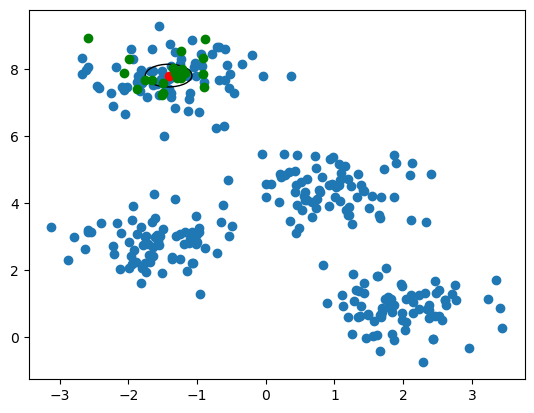

In [799]:
fig, ax = plt.subplots()

ax.scatter(X[:, 0], X[:,1])


ax.scatter(x0[0], x0[1], color='red', marker='o')

circle = plt.Circle((x0[0], x0[1]), R, color='black', fill=False)
ax.add_artist(circle)
ax.scatter(Z[:, 0], Z[:,1], color='green')

plt.show()

## Discretization
1. Draw a point $(r, \theta)$ (see r_theta)
2. Remap the point to closest point x on G

In [800]:
r_theta

NameError: name 'r_theta' is not defined

In [ ]:
from scipy.integrate import quad

""" r = distance """
def radius (r): 
    return 2 * eps * r * np.exp(-eps * r)

""" r = theta """
def theta (r): 
    return 2 * eps * r * np.exp(-eps * r)

def draw_radius(r): 

    result, error = quad(radius, 0, 2*np.pi)
    return result

def draw_theta(r):
    result, error = quad(theta, 0, np.Infinity)
    return result

def add_polar_coords(point_to_sanitize, r, theta):
    """
    Add polar coordinates (r, theta) to a vector x, where theta is in radians.
    """
    y = point_to_sanitize + r * np.column_stack((np.cos(theta), np.sin(theta)))
    return y


In [ ]:
other_locations = np.random.randn(50, 2)
point_of_interest = [1, 2]
p = np.random.uniform(0, 1)
theta = random.uniform(0, 2*math.pi)
dist = np.linalg.norm(point_of_interest-other_locations)

radius = draw_radius(dist)
d__r_theta = radius * theta
#r = np.linalg.norm(point_of_interest - other_locations)
#R = polar_laplace(r)
#print(theta, p)
print(d__r_theta, radius, theta)

9.969548119957281 2.6262291071801256 3.796145619093353


In [ ]:
from scipy.stats import gamma, uniform

r_generator = gamma(2., scale=1 / eps)
theta_generator = uniform(scale=2 * np.pi)


In [ ]:
r = r_generator.rvs()
theta = theta_generator.rvs()

In [ ]:
np.cos(theta) * r, np.sin(theta) * r

(7.633838282763048, -3.8058093886495885)

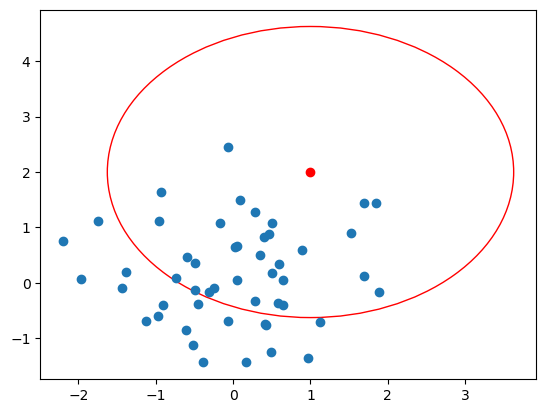

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle



# Example usage:
x = np.array(point_of_interest)  # The center of the circle
r = radius  # The radius of the circle
theta_linear = np.linspace(0, theta, 100)  # An array of angles from 0 to 2*pi
points_on_circle = add_polar_coords(x, r, theta)

# Plot the circle and random points
fig, ax = plt.subplots()
#ax.plot(points_on_circle[0], points_on_circle[1])
ax.scatter(x[0], x[1], color='red')  # Plot the center point as a red dot
ax.add_patch(Circle(x, r, fill=False, edgecolor='r'))  # Draw a red circle with center x and radius r
ax.scatter(other_locations[:, 0], other_locations[:,1])  # Plot the random points
plt.show()


## Visualize

NameError: name 'testVector' is not defined

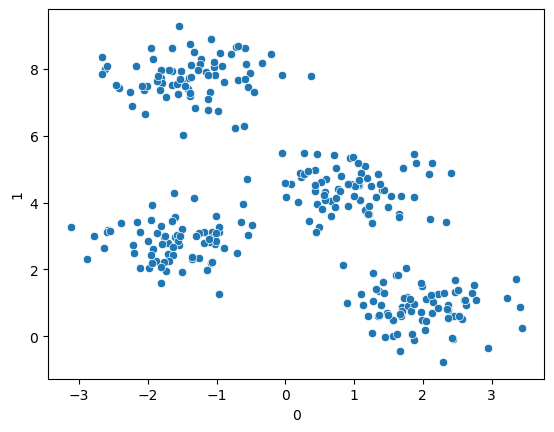

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 


# Plot the data as a scatter plot
fig, ax = plt.subplots()
sns.scatterplot(x=df.iloc[:, 0], y=df.iloc[:, 1])

# Choose a point and a radius
center = (0, testVector['x'])
radius = 0.5

# Draw a circle around the chosen point
circle = plt.Circle(center, radius, color='r', fill=False)
plt.gca().add_artist(circle)

plt.show()